This notebook is just meant to test the codes before I compile them as .py files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

# 1. Fetch coordinates (ra, dec) from raw data

In [8]:
# 6dFGS
df = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)

# ra is still in hour -> need to convert to degrees
df_test = df[['ra', 'dec']]

In [10]:
Table.from_pandas(df_test).write('6dfgs_coord.ascii', format='ipac', overwrite=True)

In [23]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df = pd.DataFrame(hdul[1].data)

df[['ra', 'dec']].describe()

,ra,dec
count,85861.000000,85861.000000
mean,172.739314,23.402422
std,90.718450,17.346885
min,0.006891,-8.783024
25%,133.475564,7.475573
50%,171.662455,22.503952
75%,219.158605,36.137900
max,359.994162,77.790749


In [13]:
# # sdss
# df = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

# df[['ra', 'dec']].describe()

# 2. Merge the spectroscopy and photometry

In [31]:
# Compare the original raw data to 2MASS (check if the order is the same)
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost_spectro = pd.DataFrame(hdul[1].data)
    
df_lamost_tmass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)

df = pd.merge(df_lamost_spectro[['ra', 'dec']], df_lamost_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']


df[['delta_ra', 'delta_dec']].describe()

,delta_ra,delta_dec
count,8.586100e+04,85861.0
mean,1.164661e-14,0.0
std,2.621386e-11,0.0
min,-4.000015e-09,0.0
25%,0.000000e+00,0.0
50%,0.000000e+00,0.0
75%,0.000000e+00,0.0
max,5.000004e-09,0.0


In [33]:
# Compare the original raw data to 2MASS
df_6df_spectro = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)
df_6df_spectro['ra'] = df_6df_spectro['ra']*15

df_6df_tmass = pd.read_csv('data/raw/2mass/6dfgs_tmass.csv', low_memory=False)

df = pd.merge(df_6df_spectro[['ra', 'dec']], df_6df_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']

df[['delta_ra', 'delta_dec']].describe()

,delta_ra,delta_dec
count,1.110200e+04,11102.0
mean,2.142063e-16,0.0
std,1.650116e-14,0.0
min,-5.684342e-14,0.0
25%,0.000000e+00,0.0
50%,0.000000e+00,0.0
75%,0.000000e+00,0.0
max,5.684342e-14,0.0


# Coba2 cross-matching

In [106]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()

df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

In [107]:
sdss_coords = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
lamost_coords = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

In [108]:
idx, sep2d, _ = lamost_coords.match_to_catalog_sky(sdss_coords)
is_counterpart = sep2d < 1.*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df_lamost = df_lamost[df_lamost['sdss_counterpart']==True]

In [109]:
df_lamost_sdss = df_lamost.merge(df_sdss, left_on='sdss_idx', right_index=True)

In [111]:
df_lamost_sdss[['ra_x', 'dec_x', 'ra_y', 'dec_y', 'veldisp_x', 'sigmaStars']]

,ra_x,dec_x,ra_y,dec_y,veldisp_x,sigmaStars
8,47.255500,-0.739480,47.255598,-0.739559,252.0,98.81241
21,146.099723,26.585136,146.099740,26.585145,176.0,158.59010
40,121.816470,6.052110,121.816460,6.052112,80.0,108.24700
42,121.637230,6.162760,121.637240,6.162754,94.0,45.21399
52,122.271720,5.976240,122.271740,5.976251,154.0,87.56513
...,...,...,...,...,...,...
85849,242.067374,3.960888,242.067370,3.960833,157.0,156.89590
85850,227.049393,27.240308,227.049390,27.240311,260.0,253.97280
85855,227.223969,26.641746,227.223890,26.641726,204.0,168.14610
85856,226.245001,27.678836,226.245000,27.678835,200.0,187.98010


## Main code for merging

### 6dFGS: Combine Vizier data (what I used throughout my thesis)

In [27]:
# FP data
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_fp = Table(hdul[1].data).to_pandas()
    
df_fp.head()

,_2MASX,Jtot,Jlogr,n,Htot,Hlogr,Ktot,Klogr,_6dFGS,No,...,Mt,Group,Nr,Ng,cz_gr,d5,sD5,Js,Hs,Ks
0,J00001440-7652248,13.177,0.605,5.43,12.490,0.503,12.206,0.401,g0000144-765225,1,...,2.2,0,0,0,0,4.2758,0.1176,1,1,1
1,J00002213-0137463,12.625,0.312,4.52,11.896,0.278,11.741,0.201,g0000222-013746,1,...,2.5,0,0,0,0,6.4318,0.0385,1,1,1
2,J00002348-0656103,12.595,0.638,6.00,11.857,0.665,11.869,0.428,g0000235-065610,1,...,3.7,0,0,0,0,6.2142,0.0448,1,1,1
3,J00002509-2602401,12.495,0.538,3.59,11.781,0.505,11.553,0.477,g0000251-260240,1,...,2.3,0,0,0,0,3.2827,0.1434,1,1,1
4,J00003564-0145472,12.242,0.800,3.24,11.605,0.770,11.281,0.804,g0000356-014547,1,...,3.0,0,0,0,0,3.8994,0.1036,1,1,1


In [28]:
# veldisp data
with fits.open('data/raw/6dfgs/sdfgs_veldisp_vizier.fits') as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()

veldisp_columns = ['_6dFGS', 'MJD', 'z', 'S_N', 'R', 'Vd', 'e_Vd', '_RA', '_DE']
df_veldisp = df_veldisp[veldisp_columns]

df_veldisp.head()

,_6dFGS,MJD,z,S_N,R,Vd,e_Vd,_RA,_DE
0,g0000144-765225,53614.60,0.0533,13.2,14.000000,129.000000,21.700001,0.059833,-76.873639
1,g0000222-013746,52962.44,0.0383,24.1,18.400000,199.100006,10.500000,0.092292,-1.629472
2,g0000235-065610,52966.46,0.0376,15.2,16.600000,156.199997,16.200001,0.097833,-6.936194
3,g0000251-260240,52846.78,0.0508,13.2,13.000000,218.500000,20.100000,0.104542,-26.044500
4,g0000356-014547,52962.44,0.0244,14.0,16.299999,133.399994,20.299999,0.148500,-1.763167


In [29]:
df_6dfgs = df_fp.merge(df_veldisp, on='_6dFGS', how='inner')

df_6dfgs

,_2MASX,Jtot,Jlogr,n,Htot,Hlogr,Ktot,Klogr,_6dFGS,No,...,Hs,Ks,MJD,z,S_N,R,Vd,e_Vd,_RA,_DE
0,J00001440-7652248,13.177,0.605,5.43,12.490,0.503,12.206,0.401,g0000144-765225,1,...,1,1,53614.60,0.0533,13.200000,14.000000,129.000000,21.700001,0.059833,-76.873639
1,J00002213-0137463,12.625,0.312,4.52,11.896,0.278,11.741,0.201,g0000222-013746,1,...,1,1,52962.44,0.0383,24.100000,18.400000,199.100006,10.500000,0.092292,-1.629472
2,J00002348-0656103,12.595,0.638,6.00,11.857,0.665,11.869,0.428,g0000235-065610,1,...,1,1,52966.46,0.0376,15.200000,16.600000,156.199997,16.200001,0.097833,-6.936194
3,J00002509-2602401,12.495,0.538,3.59,11.781,0.505,11.553,0.477,g0000251-260240,1,...,1,1,52846.78,0.0508,13.200000,13.000000,218.500000,20.100000,0.104542,-26.044500
4,J00003564-0145472,12.242,0.800,3.24,11.605,0.770,11.281,0.804,g0000356-014547,1,...,1,1,52962.44,0.0244,14.000000,16.299999,133.399994,20.299999,0.148500,-1.763167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11302,J23585991-6200483,12.242,0.631,4.54,11.547,0.622,11.361,0.579,g2358599-620048,1,...,1,1,52961.44,0.0303,28.200001,28.500000,129.899994,8.400000,359.749708,-62.013417
11303,J23590350-0524185,12.556,0.545,6.00,11.829,0.549,11.580,0.518,g2359035-052419,1,...,1,1,52966.46,0.0306,11.800000,13.600000,139.100006,22.400000,359.764542,-5.405167
11304,J23591929-3143478,12.172,0.712,4.98,11.519,0.660,11.104,0.745,g2359193-314348,1,...,1,1,52876.71,0.0280,20.900000,15.200000,187.199997,13.800000,359.830500,-31.729917
11305,J23592659-2425306,12.161,0.753,2.67,11.459,0.699,11.044,0.693,g2359266-242531,1,...,0,0,52883.61,0.0507,12.800000,11.800000,233.600006,25.299999,359.860792,-24.425139


In [42]:
df_6df_campbell = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'ra', 'dec']]
df_6df_campbell['ra'] = df_6df_campbell['ra']

In [43]:
df_compare = df_6dfgs.merge(df_6df_campbell, left_on='_6dFGS', right_on='6dFGSid')
df_compare['DELTA_RA'] = (df_compare['RAJ2000']-df_compare['ra'])*15*3600
df_compare['DELTA_DE'] = (df_compare['DEJ2000']-df_compare['dec'])*3600
df_compare[['RAJ2000', 'DEJ2000', 'ra', 'dec', 'DELTA_RA', 'DELTA_DE']]

,RAJ2000,DEJ2000,ra,dec,DELTA_RA,DELTA_DE
0,0.00399,-76.87364,0.00399,-76.87364,0.000000e+00,0.000000e+00
1,0.00615,-1.62947,0.00615,-1.62947,-4.683753e-14,7.993606e-13
2,0.00652,-6.93619,0.00652,-6.93619,-4.683753e-14,3.197442e-12
3,0.00697,-26.04450,0.00697,-26.04450,-4.683753e-14,1.278977e-11
4,0.00990,-1.76317,0.00990,-1.76317,-9.367507e-14,7.993606e-13
...,...,...,...,...,...,...
11302,23.98331,-62.01342,23.98331,-62.01342,-1.918465e-10,5.115908e-11
11303,23.98430,-5.40517,23.98430,-5.40517,-1.918465e-10,3.197442e-12
11304,23.98870,-31.72992,23.98870,-31.72992,-1.918465e-10,1.278977e-11
11305,23.99072,-24.42514,23.99072,-24.42514,-1.918465e-10,1.278977e-11


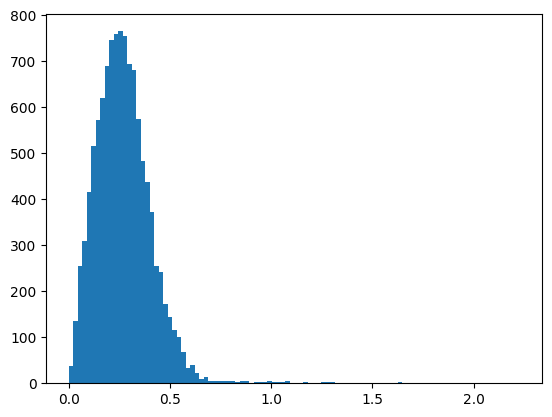

In [54]:
# Selidiki perbedaan ra_01 dec_01 (input) dan ra dan dec (dari 2MASS)
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_2 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_2)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

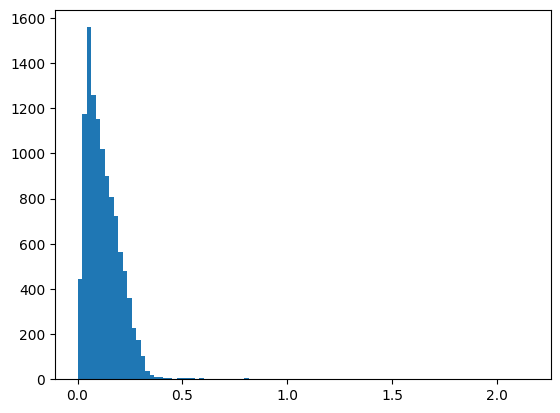

In [68]:
# Selidiki perbedaan ra_01 dec_01 dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

In [69]:
max(sep2d.arcsec)

2.148691770962743

In [71]:
len(df)

11117

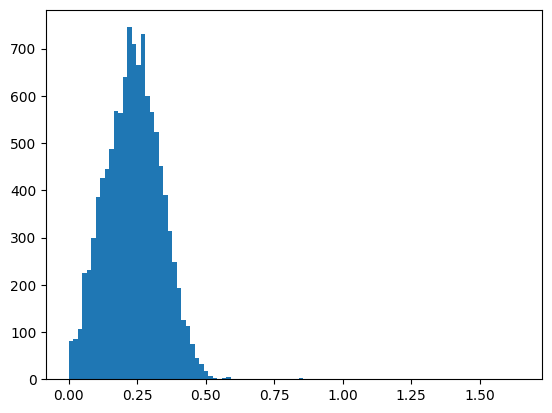

In [56]:
# Selidiki perbedaan ra dec dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

##### Eksperimen mau pake ra dec atau sup_ra dan sup_dec (dan berapa threshold yang optimal)

Min sep2d with ra and dec: 4.774033243843177
Max sep2d with ra and dec: 9.744975371367762


Min sep2d with sup_ra and sup_dec: 4.7723382973439294
Max sep2d with sup_ra and sup_dec: 9.459754889215914


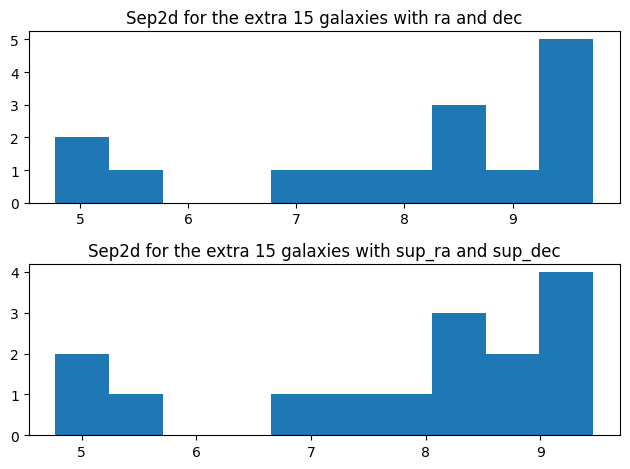

In [99]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']
    
# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'ra_01', 'dec_01', 'ra', 'dec', 'sup_ra', 'sup_dec']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Find the extra 15 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="left_only"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

Min sep2d with ra and dec: 0.0
Max sep2d with ra and dec: 2.226161234394966


Min sep2d with sup_ra and sup_dec: 0.0
Max sep2d with sup_ra and sup_dec: 2.148691770962743


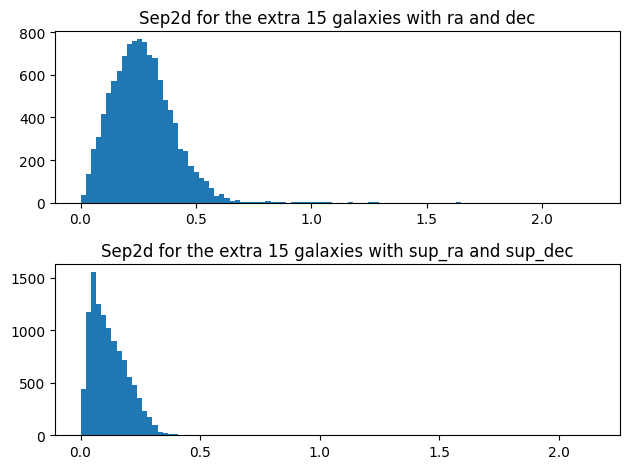

In [104]:
# Find the common 11102 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="both"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec, bins=100)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec, bins=100)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

In [126]:
# Try out the pipeline (from the original, cross-match with sup_ra and sup_dec and select sep2d < 2.5 arcsec)

# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']
df_2mass = df_2mass.sort_values(by='j_m_ext').reset_index()

# Ambil koordinatnya
coords_ori = SkyCoord(ra=df_6df['RAJ2000'].to_numpy()*u.deg, dec=df_6df['DEJ2000'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df_2mass['sup_ra'].to_numpy()*u.deg, dec=df_2mass['sup_dec'].to_numpy()*u.deg)

# Sky cross-matching
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
SEP_THRESH = 10.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_6df['tmass_idx'] = idx
df_6df['tmass_counterpart'] = is_counterpart

# df_6df = df_6df[df_6df['tmass_counterpart']==True]

df = df_6df.merge(df_2mass, left_on='tmass_idx', right_index=True)

df

,_2MASX_x,Jtot,RAJ2000,DEJ2000,tmass_idx,tmass_counterpart,index,designation,sup_ra,sup_dec,j_m_ext,j_ba,_2MASX_y
0,2MASXJ00001440-7652248,13.177,0.05985,-76.87364,7511,True,0,00001440-7652248,0.059829,-76.873642,13.177,0.6,2MASXJ00001440-7652248
1,2MASXJ00002213-0137463,12.625,0.09225,-1.62947,4499,True,1,00002213-0137463,0.092303,-1.629483,12.625,0.5,2MASXJ00002213-0137463
2,2MASXJ00002348-0656103,12.595,0.09780,-6.93619,4331,True,2,00002348-0656103,0.097852,-6.936201,12.595,0.5,2MASXJ00002348-0656103
3,2MASXJ00002509-2602401,12.495,0.10455,-26.04450,3883,True,3,00002509-2602401,0.104538,-26.044504,12.495,0.3,2MASXJ00002509-2602401
4,2MASXJ00003564-0145472,12.242,0.14850,-1.76317,2915,True,4,00003564-0145472,0.148488,-1.763180,12.242,0.8,2MASXJ00003564-0145472
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11097,2MASXJ23585991-6200483,12.242,359.74965,-62.01342,2913,True,11112,23585991-6200483,359.749725,-62.013409,12.242,1.0,2MASXJ23585991-6200483
11098,2MASXJ23590350-0524185,12.556,359.76450,-5.40517,4156,True,11113,23590350-0524185,359.764526,-5.405164,12.556,0.6,2MASXJ23590350-0524185
11099,2MASXJ23591929-3143478,12.172,359.83050,-31.72992,2676,True,11114,23591929-3143478,359.830505,-31.729927,12.172,0.5,2MASXJ23591929-3143478
11100,2MASXJ23592659-2425306,12.161,359.86080,-24.42514,2645,True,11115,23592659-2425306,359.860779,-24.425137,12.161,0.6,2MASXJ23592659-2425306


##### Eksperimen apakah bisa langsung one-to-one match aja

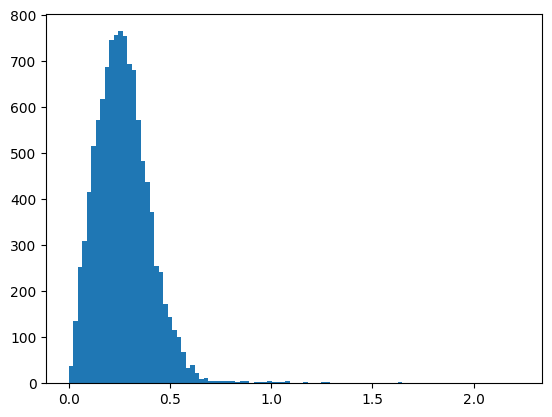

In [10]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11102 galaksi juga)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_one_to_one.csv')#[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Merge by index
df = df_6df.merge(df_2mass, left_index=True, right_index=True)

plt.hist(df['dist_x'], bins=100)
plt.show()

In [11]:
max(df.dist_x)

2.226161

## MERGING 6dFGS DATA

In [194]:
# Vizier first table (FP sample)
req_cols = ['_2MASX', 'Jlogr', 'n', 'Hlogr', 'Klogr', '_6dFGS', 'RAJ2000', 
            'DEJ2000', 'cz', 'Mt', 'Group', 'Nr', 'Ng', 'cz_gr']
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_fp = Table(hdul[1].data).to_pandas()[req_cols]
    df_fp['RAJ2000'] *= 15

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'j_mnsurfb_eff', 
            'h_r_eff', 'h_mnsurfb_eff', 'k_r_eff', 'k_mnsurfb_eff']
df_2mass = pd.read_csv('data/raw/2mass/sdfgs_tmass.csv')[req_cols]

# Merge FP + 2MASS
df = df_fp.merge(df_2mass, left_index=True, right_index=True)

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['RAJ2000'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['DEJ2000'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and 2MASS are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)

# Vizier second table (veldisp data)
req_cols = ['_2MASX', 'MJD', 'z', 'S_N', 'Vd', 'e_Vd']
with fits.open('data/raw/6dfgs/sdfgs_veldisp_vizier.fits') as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()[req_cols]
    
## Drop duplicated rows (select the one with the highest S_N)
df_veldisp = df_veldisp.sort_values(by='S_N', ascending=False)
df_veldisp = df_veldisp.drop_duplicates(subset='_2MASX')

# Merge the with the velocity dispersion data
df = df.merge(df_veldisp, on='_2MASX')

Max delta RA: 0.0
Max delta DEC: 1.4210854715202004e-14
The coordinates from the original data and 2MASS are consistent.


# MERGING SDSS DATA

In [128]:
# Open spectroscopy data
req_cols = ['objID', 'ra', 'dec', 'mjd', 'z', 'zErr', 'sigmaStars', 'sigmaStarsErr']
df_spectro = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')[req_cols]
print(f'Original number of SDSS galaxies = {len(df_spectro)}')

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv('data/raw/2mass/sdss_tmass.csv', low_memory=False)[req_cols]

# Merge FP + 2MASS and drop measurements without photometry (designation is null)
print("Merging SDSS spectroscopy with 2MASS photometry...")
df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
df = df.dropna(subset='designation').rename({'designation': 'tmass'}, axis=1)
df['tmass'] = '2MASXJ' + df['tmass']
print(f"Remaining SDSS galaxies = {len(df)}")

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and SDSS are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)
    
# Open John's measurements
req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 
            'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h', 
            'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
df_jrl = pd.read_csv('data/raw/r_e_jrl/jhk_r_e.csv')[req_cols]

# Merge SDSS_Spectro+2MASS and JRL photometry
print("Merging SDSS+2MASS with JRL photometry...")
df = df.merge(df_jrl, on='tmass')
print(f'Remaining SDSS galaxies = {len(df)}')

# Open cluster and group data
## Individual galaxies data
req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gal.fits') as hdul:
    df_gal = Table(hdul[1].data).to_pandas()[req_cols]
## Group and cluster data
req_cols = ['IDcl', 'zcl']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gr.fits') as hdul:
    df_gr = Table(hdul[1].data).to_pandas()[req_cols]
## Merge the two tables
df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

# Crossmatch SDSS data with Tempel data based on individual galaxy RA and DEC
coords_sdss = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy()*u.deg, dec=df_tempel['DEJ2000'].to_numpy()*u.deg)

idx, sep2d, _ = coords_sdss.match_to_catalog_sky(coords_tempel)
SEP_THRESH = 2.5
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df['tempel_idx'] = idx
df['tempel_counterpart'] = is_counterpart

print(f'Joining SDSS data with Tempel group and cluster data...')
df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
print(f'SDSS galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

Original number of SDSS galaxies = 353880
Merging SDSS spectroscopy with 2MASS photometry...
Remaining SDSS galaxies = 169164
Max delta RA: 0.0
Max delta DEC: 0.0
The coordinates from the original data and SDSS are consistent.
Merging SDSS+2MASS with JRL photometry...
Remaining SDSS galaxies = 96904
Joining SDSS data with Tempel group and cluster data...
SDSS galaxies that are part of a cluster: 57957


# MERGING LAMOST DATA

In [167]:
# Open spectroscopy data
req_cols = ['obsid', 'ra', 'dec', 'z_lamost', 'veldisp', 'veldisp_err']
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_spectro = Table(hdul[1].data).to_pandas()[req_cols]
print(f'Original number of LAMOST galaxies = {len(df_spectro)}')

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)[req_cols]

# Merge LAMOST spectro + 2MASS and drop measurements without photometry (designation is null)
print("Merging LAMOST spectroscopy with 2MASS photometry...")
df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
df = df.dropna(subset='designation').rename({'designation': 'tmass'}, axis=1)
df['tmass'] = '2MASXJ' + df['tmass']
print(f"Remaining LAMOST galaxies = {len(df)}")

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and LAMOST are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)
    
# Open John's measurements
req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 
            'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h', 
            'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
df_jrl = pd.read_csv('data/raw/r_e_jrl/jhk_r_e.csv')[req_cols]

# Merge LAMOST_Spectro+2MASS and JRL photometry
print("Merging LAMOST+2MASS with JRL photometry...")
df = df.merge(df_jrl, on='tmass')
print(f'Remaining LAMOST galaxies = {len(df)}')

# Open cluster and group data
## Individual galaxies data
req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gal.fits') as hdul:
    df_gal = Table(hdul[1].data).to_pandas()[req_cols]
## Group and cluster data
req_cols = ['IDcl', 'zcl']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gr.fits') as hdul:
    df_gr = Table(hdul[1].data).to_pandas()[req_cols]
## Merge the two tables
df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

# Crossmatch LAMOST data with Tempel data based on individual galaxy RA and DEC
coords_lamost = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy()*u.deg, dec=df_tempel['DEJ2000'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_tempel)
SEP_THRESH = 2.5
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df['tempel_idx'] = idx
df['tempel_counterpart'] = is_counterpart

print(f'Joining LAMOST data with Tempel group and cluster data...')
df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
print(f'LAMOST galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

Original number of LAMOST galaxies = 85861
Merging LAMOST spectroscopy with 2MASS photometry...
Remaining LAMOST galaxies = 63969
Max delta RA: 4.000014541816199e-09
Max delta DEC: 0.0
The coordinates from the original data and LAMOST are consistent.
Merging LAMOST+2MASS with JRL photometry...
Remaining LAMOST galaxies = 62997
Joining LAMOST data with Tempel group and cluster data...
LAMOST galaxies that are part of a cluster: 18449


In [168]:
df

,obsid,ra,dec,z_lamost,veldisp,veldisp_err,tmass,glon,glat,j_ba,...,log_r_h_smodel_h,log_r_h_model_h,fit_ok_h,log_r_h_app_k,log_r_h_smodel_k,log_r_h_model_k,fit_ok_k,tempel_counterpart,IDcl,zcl
0,705234,352.671581,30.433788,0.066654,261.0,14.0,2MASXJ23304119+3026018,102.984,-29.291,0.7,...,0.396,0.220,OK,0.459,0.457,0.302,OK,False,18212,0.15358
1,707208,355.153356,29.519402,0.065184,147.0,16.0,2MASXJ23403677+2931092,104.973,-30.871,0.7,...,0.470,0.363,OK,0.469,0.474,0.375,OK,False,17041,0.02861
2,710232,351.716122,31.342117,0.052739,148.0,7.0,2MASXJ23265188+3120314,102.482,-28.149,0.6,...,0.548,0.441,OK,0.489,0.496,0.333,OK,False,18212,0.15358
3,1103042,44.895855,27.681911,0.095125,269.0,17.0,2MASXJ02593501+2740552,154.795,-27.146,1.0,...,0.340,0.063,OK,0.278,0.278,0.020,OK,False,41600,0.02807
4,1105091,45.578044,26.790075,0.036092,95.0,13.0,2MASXJ03021875+2647239,155.910,-27.573,1.0,...,0.280,0.005,OK,0.332,0.328,0.053,OK,False,41600,0.02807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62992,746213054,227.254368,26.497579,0.110461,165.0,13.0,2MASXJ15090106+2629511,39.738,59.393,1.0,...,0.214,0.000,NOK,0.000,0.000,0.000,NOK,False,34447,0.03131
62993,746213069,227.223969,26.641746,0.070193,204.0,9.0,2MASXJ15085374+2638301,40.010,59.443,0.6,...,0.369,0.190,OK,0.318,0.276,0.000,NOK,True,34443,0.07387
62994,746213154,226.245001,27.678836,0.076094,200.0,14.0,2MASXJ15045875+2740440,41.824,60.447,1.0,...,0.253,0.000,NOK,0.360,0.360,0.033,OK,False,32908,0.10065
62995,746213196,227.103277,27.522263,0.078792,153.0,9.0,2MASXJ15082477+2731201,41.701,59.673,0.5,...,0.423,0.246,OK,0.463,0.458,0.315,OK,False,36567,0.16112


In [3]:
# Compare z_lamost and z_ppxf to SDSS redshift
df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')[['ra', 'dec', 'z']]

with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()[['ra', 'dec', 'z_lamost', 'z_ppxf']]

# Sky crossmatch SDSS vs LAMOST
coords_sdss = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
coords_lamost = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_sdss)
SEP_THRESH = 1.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df = df_lamost.merge(df_sdss, left_on='sdss_idx', how='left', right_index=True)#.drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
df = df[df.sdss_counterpart==True]

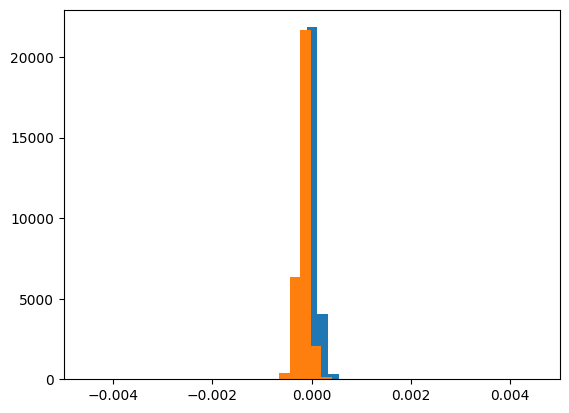

,delta_z_lamost,delta_z_ppxf
count,30690.000000,30690.000000
mean,-0.000021,-0.000196
std,0.002025,0.002021
min,-0.153966,-0.154077
25%,-0.000052,-0.000221
50%,0.000008,-0.000164
75%,0.000072,-0.000106
max,0.060635,0.059897


In [6]:
df['delta_z_lamost'] = df['z'] - df['z_lamost']
df['delta_z_ppxf'] = df['z'] - df['z_ppxf']

plt.hist(df['delta_z_lamost'], bins=1000)
plt.hist(df['delta_z_ppxf'], bins=1000)

plt.xlim(-0.005, 0.005)
plt.show()

df[['delta_z_lamost', 'delta_z_ppxf']].describe()

(-0.0006, 0.0006)

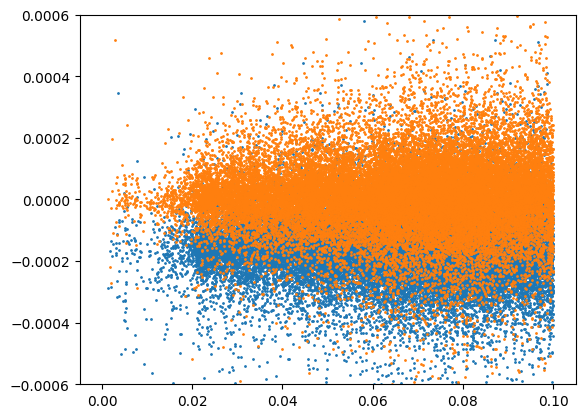

In [9]:
plt.scatter(df.z, df['delta_z_ppxf'], s=1)
plt.scatter(df.z, df['delta_z_lamost'], s=1)
plt.ylim(-0.0006, 0.0006)

In [2]:
!ls

LICENSE          docs             notebook.ipynb   venv
README.md        etc              requirements.txt
data             log              src


In [35]:
df = pd.read_csv('data/preprocessed/spectrophoto/sdss.csv')

In [36]:
df.columns

Index(['objID', 'ra', 'dec', 'mjd', 'z', 'zErr', 'sigmaStars', 'sigmaStarsErr',
       'tmass', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 'sup_ba', 'r_ext',
       'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff',
       'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j',
       'red_chi_j', 'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h',
       'fit_ok_h', 'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k',
       'fit_ok_k', 'tempel_counterpart', 'IDcl', 'zcl'],
      dtype='object')

# DERIVE $r, s, i$

In [18]:
# Constants
LIGHTSPEED = 299792.458

# File names
SURVEY_LIST = ['6dFGS', 'SDSS', 'LAMOST']

SURVEY_ID_COL_NAME = {
    'SDSS': 'objID',
    'LAMOST': 'obsid'
}

# A variable to store the aperture sizes and veldisp column names
SPECTROSCOPY_CONFIG = {
    '6dFGS': {
        'aperture_size': 3.35,
        'veldisp_col_name': 'Vd',
        'veldisp_err_col_name': 'e_Vd'
    },
    'SDSS': {
        'aperture_size': 1.5,
        'veldisp_col_name': 'sigmaStars',
        'veldisp_err_col_name': 'sigmaStarsErr'
    },
    'LAMOST': {
        'aperture_size': 1.65,
        'veldisp_col_name': 'veldisp',
        'veldisp_err_col_name': 'veldisp_err'
    }
}

# Galactic extinction constants in the JHK bands
EXTINCTION_CONSTANT = {
    'j': 0.723,
    'h': 0.460,
    'k': 0.310
}

# Sun absolute magnitude constants
SOLAR_MAGNITUDE = {
    'j': 3.67,
    'h': 3.32,
    'k': 3.27
}

for survey in SURVEY_LIST[1:2]:
    '''
    A function to derive r, s, i quantities for each galaxy in the three surveys.
    '''
    # Open spectroscopy+photometry file
    df = pd.read_csv(f'data/preprocessed/spectrophoto/{survey.lower()}.csv')
    print(f'Original number of {survey} galaxies = {len(df)} galaxies.')

    # Extra step only for SDSS and LAMOST
    if survey in ['SDSS', 'LAMOST']:
        
        # Add prefixes to the survey ID's to convert them to object type
        # Only for SDSS and LAMOST as 6dFGS ID's are already object type
        df[SURVEY_ID_COL_NAME[survey]] = survey + df[SURVEY_ID_COL_NAME[survey]].astype(str)
        
        # Select only good J-band radii
        # Selection criteria (from John): fit_OK, r_model > 1 arcsec, reduced chi <= 2.
        df = df[df['fit_ok_j'] == 'OK']
        print(f"Selected galaxies with fit_ok_j == 'OK'. Remaining galaxies = {len(df)}")
        
        df = df[df['log_r_h_model_j'] > 0.]
        print(f"Selected galaxies with log_r_h_model_j > 0. Remaining galaxies = {len(df)}")
        
        df = df[df['red_chi_j'] <= 2.]
        print(f"Selected galaxies with red_chi_j <= 2. Remaining galaxies = {len(df)}")
        
    # ============================================ DERIVING RELEVANT QUANTITIES ====================================#

    # Derive PSF-corrected radii
    print('Deriving PSF-corrected radii...')
    for band in 'jhk':
        if survey == '6dFGS':
            df[f'theta_{band}'] = 10 ** df[f'{band.upper()}logr']
        else:
            df[f'delta_r_{band}'] = 10 ** (df[f'log_r_h_smodel_{band}']) - 10 ** (df[f'log_r_h_model_{band}'])
            df[f'theta_{band}'] = 10 ** (df[f'log_r_h_app_{band}']) - df[f'delta_r_{band}']

    # Calculate CMB frame redshift for individual galaxies (also rederive for 6dFGS)
    from src.utils.helio_cmb import perform_corr
    print('Calculating CMB frame redshift for each galaxy...')
    df['z_cmb'] = perform_corr(df['z'], df['ra'], df['dec'], corrtype='full', dipole='Planck')
    
    # Use group/cluster redshift for galaxies in group/cluster
    print('Obtaining group/cluster mean redshift if available...')
    if survey in ['SDSS', 'LAMOST']:
        df['z_dist_est'] = np.where(df['tempel_counterpart'] == True, df['zcl'], df['z_cmb'])
    else:
        df['z_dist_est'] = np.where(df['cz_gr'] != 0., df['cz_gr'] / LIGHTSPEED, df['z_cmb'])

    # Aperture size corrections for the velocity dispersions
    print('Calculating aperture size-corrected velocity dispersions...')
    # Convert J-band radii to R-band radii
#     R_j = 10 ** (1.029 * np.log10(df['theta_j']) + 0.140)
    R_j = 10 ** (1.029 * np.log10(df['theta_j'] * np.sqrt(df['j_ba'])) + 0.140)
    
    aperture_size = SPECTROSCOPY_CONFIG[survey]['aperture_size']
    veldisp_col = SPECTROSCOPY_CONFIG[survey]['veldisp_col_name']
    veldisp_err_col = SPECTROSCOPY_CONFIG[survey]['veldisp_err_col_name']
    
    df['sigma_corr'] = df[veldisp_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    df['e_sigma_corr'] = df[veldisp_err_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    

    # Calculate Galactic extinctions in the JHK bands
    print('Calculating Galactic extinctions in the JHK band...')
    from dustmaps.sfd import SFDQuery
    from astropy.coordinates import SkyCoord
    from dustmaps.config import config

    config['data_dir'] = 'etc/dustmaps'
    sfd = SFDQuery()
    coords = SkyCoord(df['ra'], df['dec'], unit='deg', frame ='fk5')
    ebv = sfd(coords)
    for band in 'jhk':
        extinction_constant = EXTINCTION_CONSTANT[band]
        df[f'extinction_{band}'] = extinction_constant * ebv


    # Calculate k-corrections
    from src.utils.calc_kcor import calc_kcor
    
    print('Calculating K-corrections...')
    z = df['z'].to_numpy()
    color_J2H2 = (df['j_m_ext'] - df['extinction_j']) - (df['h_m_ext'] - df['extinction_h']).to_numpy()
    color_J2Ks2 = (df['j_m_ext'] - df['extinction_j']) - (df['k_m_ext'] - df['extinction_k']).to_numpy()
    df['kcor_j'] = calc_kcor('J2', z, 'J2 - H2', color_J2H2)
    df['kcor_h'] = calc_kcor('H2', z, 'J2 - H2', color_J2H2)
    df['kcor_k'] = calc_kcor('Ks2', z, 'J2 - Ks2', color_J2Ks2)


    # ============================= DERIVING r, s, i ================================#

    # Derive r and i
    from src.utils.CosmoFunc import rz_table
    from scipy import interpolate
    
    ## Get redshift-distance lookup table
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    ## Comoving distance for individual galaxies
    dz = interpolate.splev(df["z_cmb"].to_numpy(), dist_spline)
    ## Comoving distance for group galaxies
    dz_cluster = interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline)
    ## Use the circularized effective radii
    for band in 'jhk':
        circularized_radius = df[f'theta_{band}'] * np.sqrt(df[f'{band}_ba'])
        df[f'r_{band}'] = np.log10(circularized_radius) + np.log10(dz_cluster) \
                          + np.log10(1000.0 * np.pi / (180.0 * 3600.0)) - np.log10(1.0 + df['z'].to_numpy())
        
        df[f'i_{band}'] = 0.4 * SOLAR_MAGNITUDE[band] - 0.4 * df[f'{band}_m_ext'] - np.log10(2.0 * np.pi) \
                          - 2.0 * np.log10(circularized_radius) + 4.0 * np.log10(1.0 + df['z']) \
                          + 0.4 * df[f'kcor_{band}'] + 0.4 * df[f'extinction_{band}'] \
                          + 2.0 * np.log10(180.0 * 3600.0 / (10.0*np.pi))

    # Derive s
    df['s'] = np.log10(df['sigma_corr'])
    df['es'] = (df['e_sigma_corr'] / df['sigma_corr']) / np.log(10)
    
#     # Remove extreme outliers and zero errors in es (only in SDSS)
#     if file in 'sdss':
#         data = data[data['es']<data['es'].quantile(0.995)]
#         data = data[data['es']>0.]

    # Save the data
#     data.to_csv('../data/FP_observables/1st_step/' + file + '.csv',index=False)

Original number of SDSS galaxies = 91497 galaxies.
Selected galaxies with fit_ok_j == 'OK'. Remaining galaxies = 89691
Selected galaxies with log_r_h_model_j > 0. Remaining galaxies = 89691
Selected galaxies with red_chi_j <= 2. Remaining galaxies = 89285
Deriving PSF-corrected radii...
Calculating CMB frame redshift for each galaxy...
Obtaining group/cluster mean redshift if available...
Calculating aperture size-corrected velocity dispersions...
Calculating Galactic extinctions in the JHK band...
Calculating K-corrections...


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
df['sigmaStarsErr'].describe()

count    89285.000000
mean         7.193173
std         17.103387
min          0.000000
25%          5.031053
50%          6.290223
75%          7.690755
max        990.840100
Name: sigmaStarsErr, dtype: float64

In [32]:
df_campbell = pd.read_csv(f'data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'logsigma', 'elogsigma']]
df_slice = df[['_6dFGS', 's', 'es']]

df_merge = df_campbell.merge(df_slice, left_on='6dFGSid', right_on='_6dFGS')

df_merge['delta_s'] = df_merge['logsigma'] - df_merge['s']
df_merge['delta_es'] = df_merge['elogsigma'] - df_merge['es']

df_merge

,6dFGSid,logsigma,elogsigma,_6dFGS,s,es,delta_s,delta_es
0,g0000144-765225,2.137,0.073,g0000144-765225,2.141779,0.073056,-0.004779,-0.000056
1,g0000222-013746,2.338,0.023,g0000222-013746,2.343950,0.022904,-0.005950,0.000096
2,g0000235-065610,2.219,0.045,g0000235-065610,2.225142,0.045042,-0.006142,-0.000042
3,g0000251-260240,2.369,0.040,g0000251-260240,2.379594,0.039951,-0.010594,0.000049
4,g0000356-014547,2.144,0.066,g0000356-014547,2.145748,0.066088,-0.001748,-0.000088
...,...,...,...,...,...,...,...,...
11097,g2358599-620048,2.139,0.028,g2358599-620048,2.139163,0.028084,-0.000163,-0.000084
11098,g2359035-052419,2.172,0.070,g2359035-052419,2.176986,0.069937,-0.004986,0.000063
11099,g2359193-314348,2.295,0.032,g2359193-314348,2.300721,0.032015,-0.005721,-0.000015
11100,g2359266-242531,2.389,0.047,g2359266-242531,2.393570,0.047036,-0.004570,-0.000036


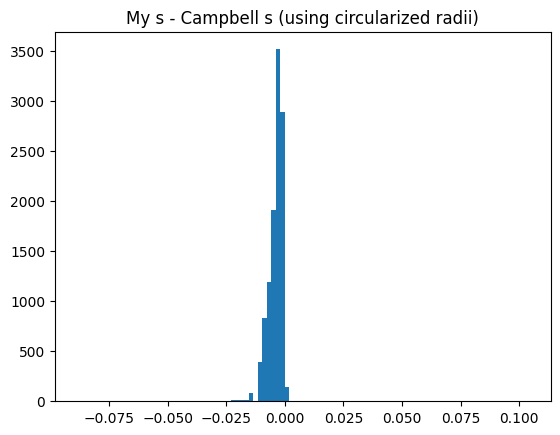

In [34]:
plt.hist(df_merge['delta_s'], bins=100)
plt.title('My s - Campbell s (using circularized radii)')
plt.show()

In [2]:
from src.utils.constants import *

LIGHTSPEED

299792.458